In [1]:
import pandas as pd

hex_coords = pd.read_csv("../Raw-Data/hex_center_coordinates_IM-1594_07252023.csv")
hex_coords

,hex_label,x,y
0,1,317.043701,377.689785
1,2,154.804648,81.013518
2,3,473.678140,78.016680
3,4,316.732333,344.559264
4,5,343.149441,327.744268
5,6,290.003859,328.243741
6,7,342.838073,294.613747
7,8,289.692491,295.113220
8,9,369.255181,277.798750
9,10,316.109599,278.298223


In [2]:
from src.load_data import load_data

position_info, spikes, multiunit_firing_rate, multiunit_HSE_times = load_data(
    position_file_name="/Users/edeno/Documents/GitHub/tk_decoding/Raw-Data/IM-1594_07252023_position.csv",
    spike_file_name="/Users/edeno/Documents/GitHub/tk_decoding/Raw-Data/IM-1594_07252023_spikesWithPosition.csv"
)

In [3]:
from src.parameters import CM_PER_PIXEL
from src.load_data import flip_y


In [4]:
hex_coords[["x", "y"]] = (
    flip_y(
        hex_coords[["x", "y"]].to_numpy(),
        hex_coords[["x", "y"]].max().to_numpy(),
    )
    * CM_PER_PIXEL
)

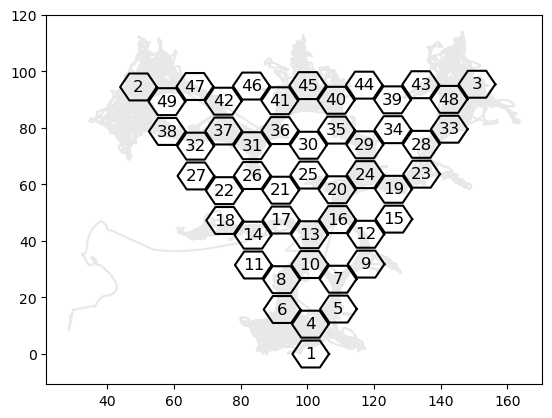

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def draw_hex(x, y, radius=5.5, color="black", ax=None, **kwargs):
    """Draw a hexagon centered at x, y with the given size and color."""
    if ax is None:
        ax = plt.gca()
    # Calculate the angles and the coordinates of the vertices
    theta = np.linspace(0, 2 * np.pi, 7)

    ax.plot(x + radius * np.cos(theta), y + radius * np.sin(theta), color=color, **kwargs)

plt.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plt.scatter(hex_coords['x'], hex_coords['y'], s=1, alpha=0.0)
# hex_size = hex_coords.iloc[1]
# plt.hexbin(hex_coords['x'], hex_coords['y'], gridsize=10, cmap='bone')
for _, row in hex_coords.iterrows():
    plt.text(row['x'], row['y'], int(row['hex_label']), fontsize=12, ha='center', va='center')
    draw_hex(row['x'], row['y'], radius=5.5, color="black")
# plt.axis(False)

In [36]:
np.linalg.norm(hex_coords.set_index('hex_label').loc[2].to_numpy() - hex_coords.set_index('hex_label').loc[49].to_numpy())

9.972820363943155

In [37]:
np.linalg.norm(hex_coords.set_index('hex_label').loc[49].to_numpy() - hex_coords.set_index('hex_label').loc[38].to_numpy())

10.551587199257332

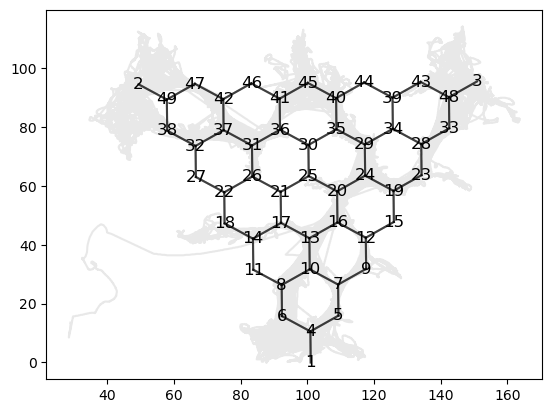

In [76]:
# edge connectivity - nearest neighbors
plt.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plt.scatter(hex_coords['x'], hex_coords['y'], s=1, alpha=0.0)

for _, row in hex_coords.iterrows():
    plt.text(row['x'], row['y'], int(row['hex_label']), fontsize=12, ha='center', va='center')

edges = []
for _, row in hex_coords.iterrows():
    for _, row2 in hex_coords.iterrows():
        if row['hex_label'] == row2['hex_label']:
            continue
        if np.linalg.norm(row[['x', 'y']] - row2[['x', 'y']]) < 11:
            plt.plot([row['x'], row2['x']], [row['y'], row2['y']], color='black', alpha=0.5)
            edges.append((int(row['hex_label']), int(row2['hex_label'])))


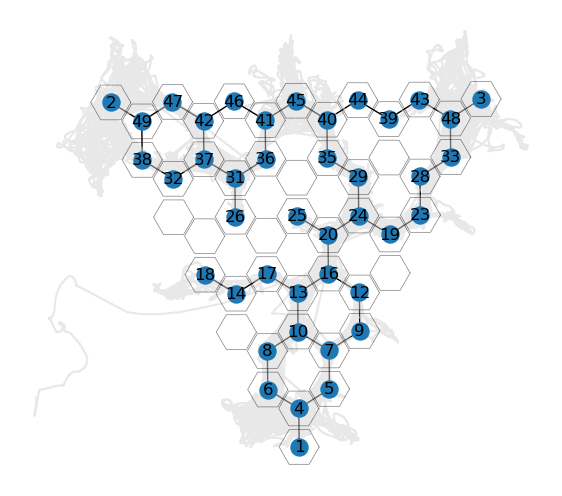

In [107]:
import networkx as nx

def hex_occupied(hex_label, position_info, hex_radius=5.5):
    hex_center = hex_coords.set_index('hex_label').loc[hex_label]
    return np.any(np.linalg.norm(position_info[['x', 'y']] - hex_center[['x', 'y']], axis=1) < hex_radius)

G = nx.Graph()
hex_radius = 5.5

valid_nodes = [
    int(row.hex_label)
    for row in hex_coords.itertuples(index=False)
    if hex_occupied(row.hex_label, position_info, hex_radius=hex_radius)
]

edges = []
for hex_label, row in hex_coords.set_index("hex_label").loc[valid_nodes].iterrows():
    for hex_label2, row2 in hex_coords.set_index("hex_label").loc[valid_nodes].iterrows():
        if hex_label == hex_label2:
            continue
        if np.linalg.norm(row[['x', 'y']] - row2[['x', 'y']]) < hex_radius * 2:
            edges.append((int(hex_label), int(hex_label2)))

G.add_nodes_from([(node, {"x": row.x, "y": row.y}) for node, row in hex_coords.set_index("hex_label").loc[valid_nodes].iterrows()])
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(7, 7))
plt.gca().set_aspect('equal')
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
pos_map = {label: (x, y) for label, (x, y) in hex_coords.set_index('hex_label').iterrows()}
nx.draw(G, pos=pos_map, with_labels=True, node_size=150, ax=ax)

for _, row in hex_coords.iterrows():
    draw_hex(row['x'], row['y'], radius=5.5, color="black", ax=ax, linewidth=0.5, alpha=0.5)

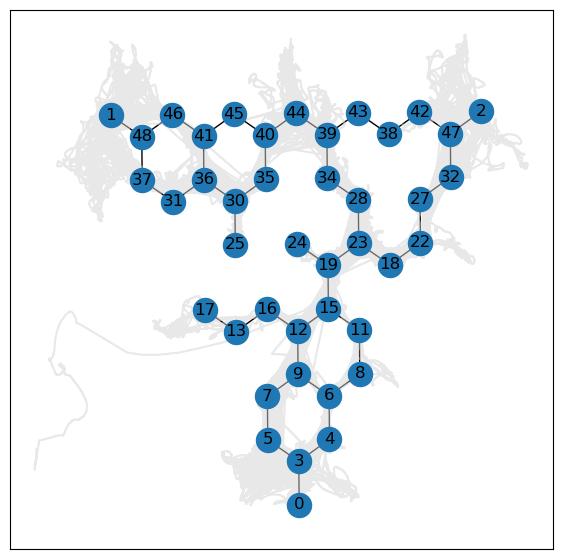

In [146]:
from track_linearization import make_track_graph, plot_track_graph

track_graph = make_track_graph(hex_coords[["x", "y"]].to_numpy(), np.array(edges) - 1)
track_graph.remove_nodes_from(list(nx.isolates(track_graph)))

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

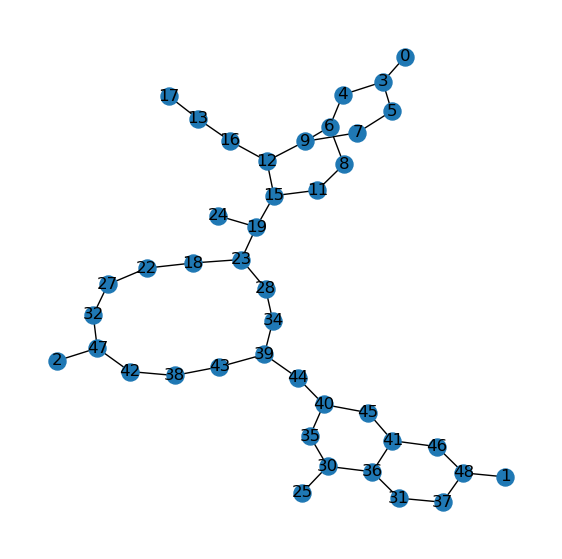

In [148]:
fig, ax = plt.subplots(figsize=(7, 7))
nx.draw_kamada_kawai(track_graph, with_labels=True, node_size=150, ax=ax)

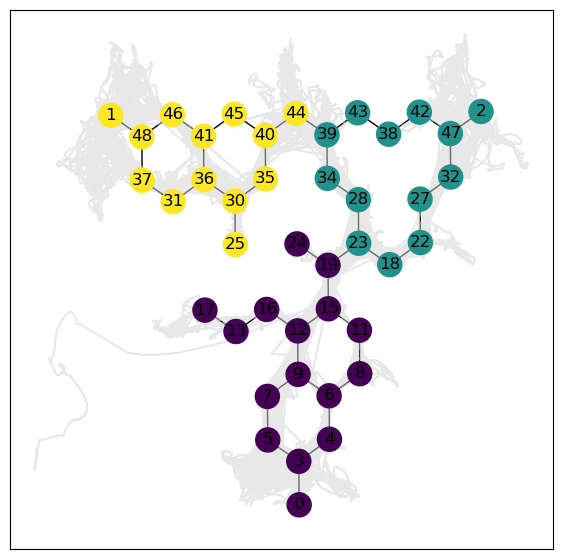

In [240]:
# color nodes by community
communities = nx.community.greedy_modularity_communities(track_graph, n_communities=3, best_n=3)
# communities = nx.community.louvain_communities(track_graph, resolution=0.5)
node_color = np.zeros(len(track_graph.nodes))
node_list = list(track_graph.nodes)
for i, community in enumerate(communities):
    for node in community:
        node_color[node_list.index(node)] = i

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax, node_color=node_color)

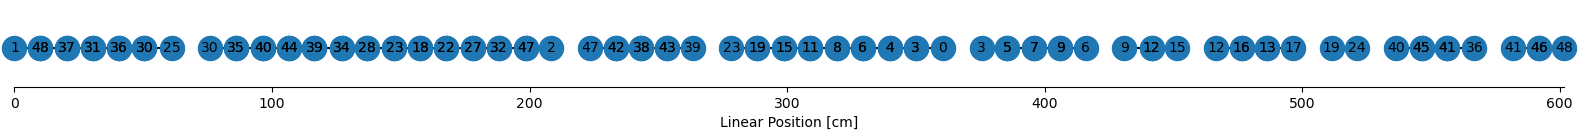

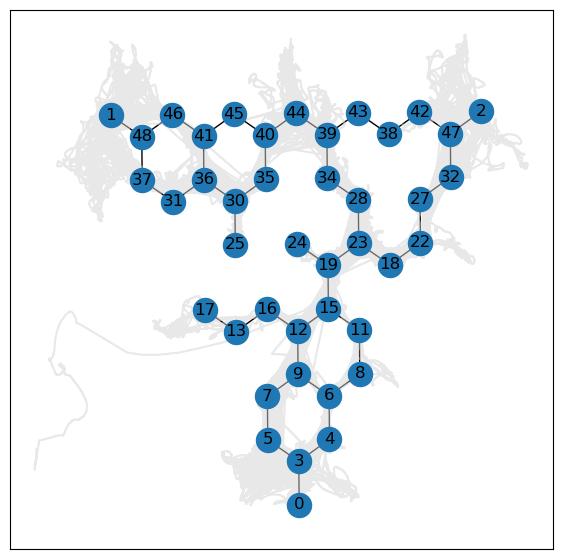

In [327]:
from track_linearization import plot_graph_as_1D
from scipy.ndimage import label

linear_edge_order = list(nx.traversal.edge_dfs(track_graph, source=1))
is_connected_component = ~(np.abs(np.array(linear_edge_order)[:-1, 1] - np.array(linear_edge_order)[1:, 0]) > 0)
label_ids, n_labels = label(is_connected_component)

linear_edge_spacing = ~is_connected_component * 15.0



fig, ax = plt.subplots(figsize=(20, 1))
plot_graph_as_1D(track_graph, linear_edge_order, linear_edge_spacing, ax=ax)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

In [328]:
label_ids, n_labels = label(is_connected_component)
label_ids

array([1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3,
       0, 4, 4, 4, 4, 4, 4, 4, 0, 5, 5, 5, 0, 6, 0, 7, 7, 0, 0, 8, 8, 0,
       9], dtype=int32)

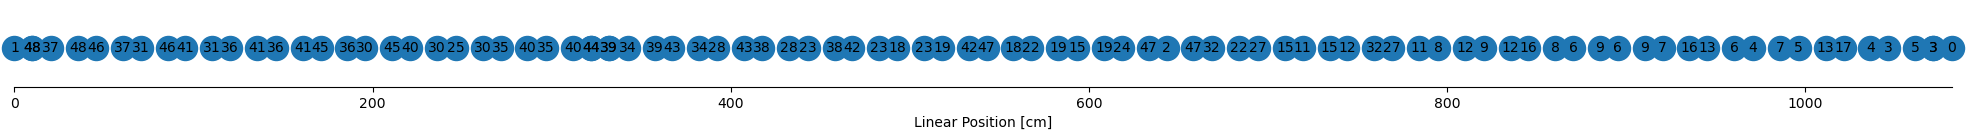

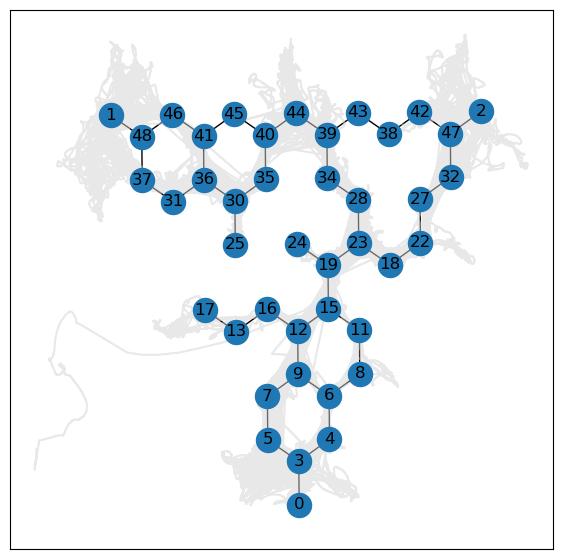

In [329]:
from track_linearization import plot_graph_as_1D
from scipy.ndimage import label

linear_edge_order = list(nx.traversal.edge_bfs(track_graph, source=1))
is_connected_component = ~(np.abs(np.array(linear_edge_order)[:-1, 1] - np.array(linear_edge_order)[1:, 0]) > 0)
linear_edge_spacing = ~is_connected_component * 15.0



fig, ax = plt.subplots(figsize=(25, 1))
plot_graph_as_1D(track_graph, linear_edge_order, linear_edge_spacing, ax=ax)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

In [ ]:
# categorize position by centripidal or centrifugal direction
# In 2D, first determine which hexagon the animal is in.
# Then determine the connected hexagons. nx.neighbors(G, node)
# Then determine the angle between the current hexagon and the connected hexagons.
# Then determine the direction of the angle of the animal from the previous time point to the current time point.
# Then determine the most similar angle between the connected hexagons and the direction of the animal.
# Assign the direction of the animal to the most similar angle between the connected hexagons.
# If the direction is inbound to the central node, label the movement inbound.
# If the direction is outbound from the central node, label the movement outbound.

def categorize_position(position_info, hex_coords, track_graph):
    position_info['direction'] = np.nan
    for i, row in position_info.iterrows():
        hex_label = np.argmin(np.linalg.norm(hex_coords[['x', 'y']] - row[['x', 'y']], axis=1))
        connected_hex_labels = list(track_graph.neighbors(hex_label))
        connected_hex_coords = hex_coords.set_index('hex_label').loc[connected_hex_labels]
        angles = np.arctan2(connected_hex_coords['y'] - row['y'], connected_hex_coords['x'] - row['x'])
        direction = np.arctan2(row['y'] - position_info.iloc[i - 1]['y'], row['x'] - position_info.iloc[i - 1]['x'])
        angle_diff = np.abs(angles - direction)
        closest_angle = angles[np.argmin(angle_diff)]
        position_info.loc[i, 'direction'] = closest_angle

array([ 0.52101878, -0.99995584])

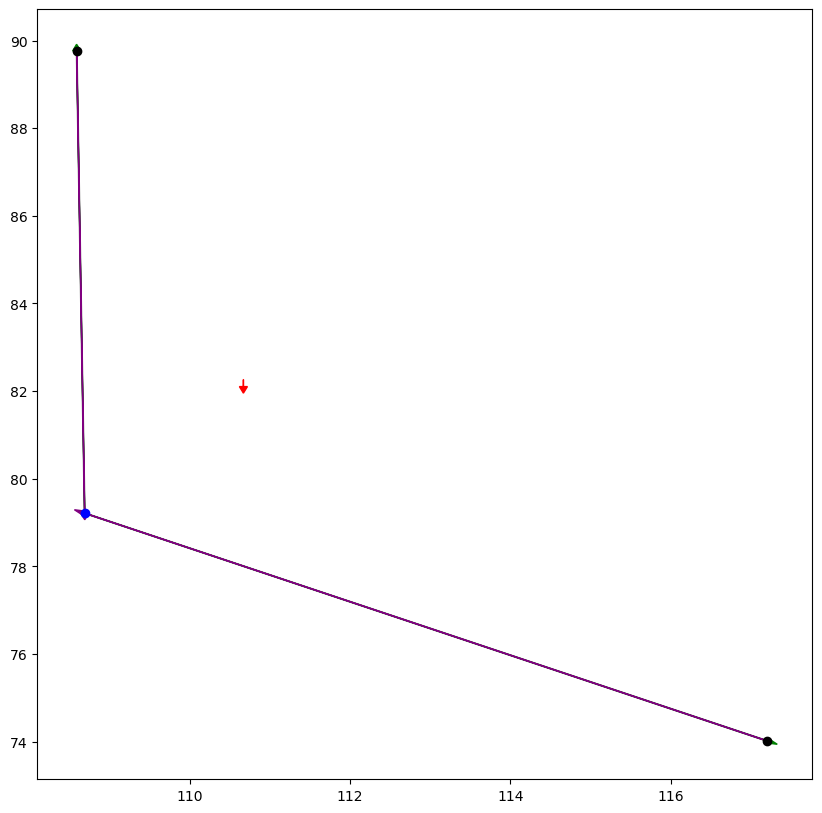

In [408]:
import scipy.spatial

position = position_info[['x', 'y']].to_numpy()

node_positions = nx.get_node_attributes(track_graph, 'pos')

time_ind = 210_000

cur_pos = position[time_ind]
cur_node = min(node_positions, key=lambda x: np.linalg.norm(node_positions[x] - cur_pos))
connected_nodes = list(track_graph.neighbors(cur_node))


fig, ax = plt.subplots(figsize=(10, 10))
plt.arrow(position[time_ind-1][0], position[time_ind-1][1],
          position[time_ind][0] - position[time_ind-1][0],
          position[time_ind][1] - position[time_ind-1][1], color='red', head_width=0.1)

plt.scatter(node_positions[cur_node][0], node_positions[cur_node][1], color='blue', zorder=10, label='current node')
plt.scatter([node_positions[node][0] for node in connected_nodes],
            [node_positions[node][1] for node in connected_nodes], color='black', zorder=10, label='connected nodes')

for node in connected_nodes:
    plt.plot([node_positions[cur_node][0], node_positions[node][0]],
             [node_positions[cur_node][1], node_positions[node][1]], color='black', alpha=0.5)
    # outgoing arrow
    plt.arrow(node_positions[cur_node][0], node_positions[cur_node][1],
              node_positions[node][0] - node_positions[cur_node][0],
              node_positions[node][1] - node_positions[cur_node][1], color='green', head_width=0.1, alpha=1, zorder=5)
    # incoming arrow
    plt.arrow(node_positions[node][0], node_positions[node][1],
              node_positions[cur_node][0] - node_positions[node][0],
              node_positions[cur_node][1] - node_positions[node][1], color='purple', head_width=0.1, alpha=1, zorder=5)


# similarity of position vector to connected node vectors

connected_node_vectors = np.array([node_positions[node] for node in connected_nodes])
connected_node_vectors = connected_node_vectors - node_positions[cur_node]
position_vector = position[time_ind] - position[time_ind-1]

cosine_similarity = np.dot(connected_node_vectors, position_vector) / (
    np.linalg.norm(connected_node_vectors, axis=1) * np.linalg.norm(position_vector)
)

cosine_similarity

In [351]:
import scipy.spatial
1 - scipy.spatial.distance.cosine([0, 1], [0, 1])

1

In [385]:
position[time_ind] - position[time_ind - 1]

array([0., 0.])

In [445]:
# Assume center_node is the center node
closeness_centrality = nx.centrality.closeness_centrality(track_graph, distance="weight")

# Find the node with the highest closeness centrality
center_node = max(closeness_centrality, key=closeness_centrality.get)

# Initialize lists to store the centripetal and centrifugal edges
centripetal_edges = []
centrifugal_edges = []

# Classify each edge direction as centripetal or centrifugal
for u, v in track_graph.edges():
    if closeness_centrality[u] < closeness_centrality[v]:
        centripetal_edges.append((u, v))
    else:
        centrifugal_edges.append((u, v))

    if closeness_centrality[v] < closeness_centrality[u]:
        centripetal_edges.append((v, u))
    else:
        centrifugal_edges.append((v, u))

Text(0.5, 1.0, 'Centrifugal edges (away from center)')

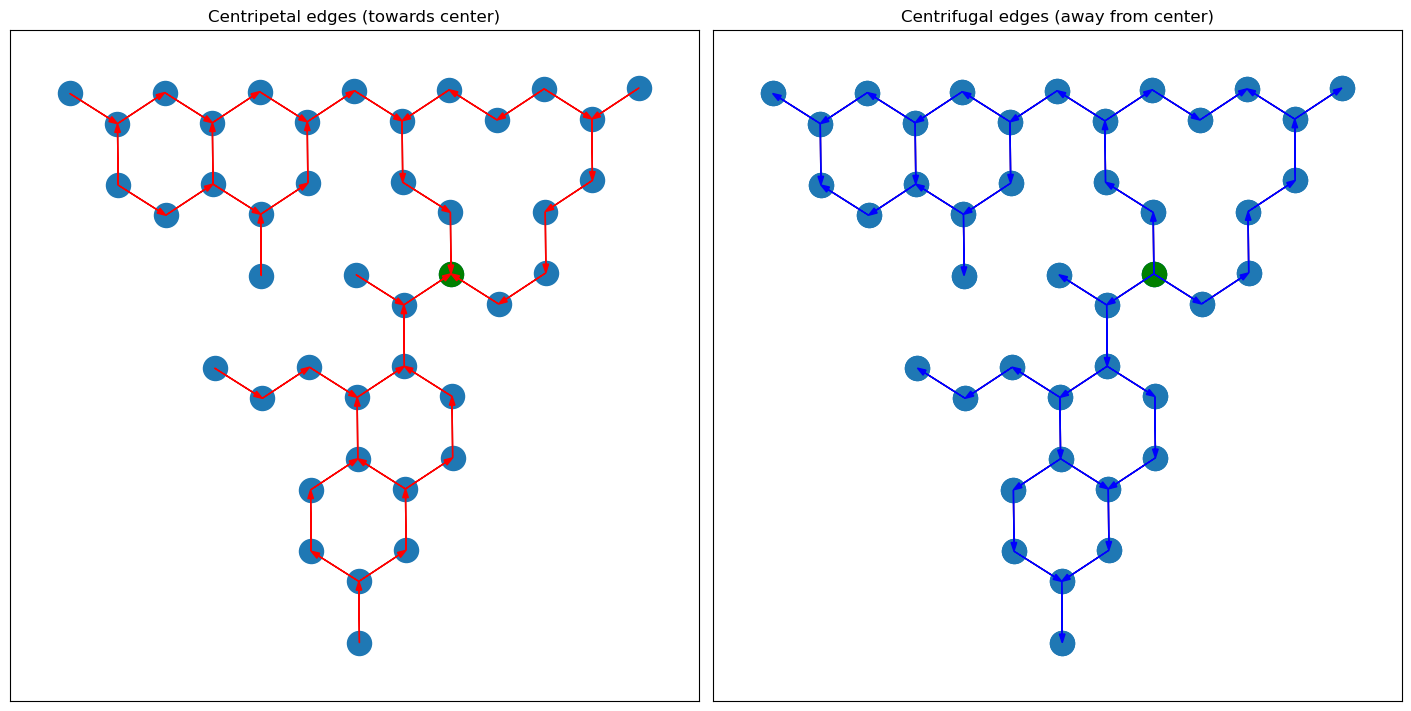

In [446]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True, constrained_layout=True)
# Draw the nodes of the graph
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[0])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[0])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[0])

for u, v in centripetal_edges:
    axes[0].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='red', head_width=1, zorder=10,
                  length_includes_head=True)
axes[0].set_title("Centripetal edges (towards center)")

# Draw the centripetal edge direction
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])

nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edgelist=centrifugal_edges, edge_color='r', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[1])
for u, v in centrifugal_edges:
    axes[1].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='blue', head_width=1, zorder=10,
                  length_includes_head=True)
axes[1].set_title("Centrifugal edges (away from center)")

In [451]:
from track_linearization import get_linearized_position

linear_position_info = get_linearized_position(
    position_info[['x', 'y']].to_numpy(),
    track_graph,
    edge_order=linear_edge_order,
    edge_spacing=linear_edge_spacing,
    use_HMM=False)

linear_position_info

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,1021.355245,16,75.135087,47.241444
1,1021.355245,16,75.135087,47.241444
2,1021.355245,16,75.135087,47.241444
3,1021.355245,16,75.135087,47.241444
4,1021.355245,16,75.135087,47.241444
...,...,...,...,...
1613512,1075.494511,0,100.909581,6.357680
1613513,1075.494511,0,100.909581,6.357680
1613514,1075.494511,0,100.909581,6.357680
1613515,1075.494511,0,100.909581,6.357680


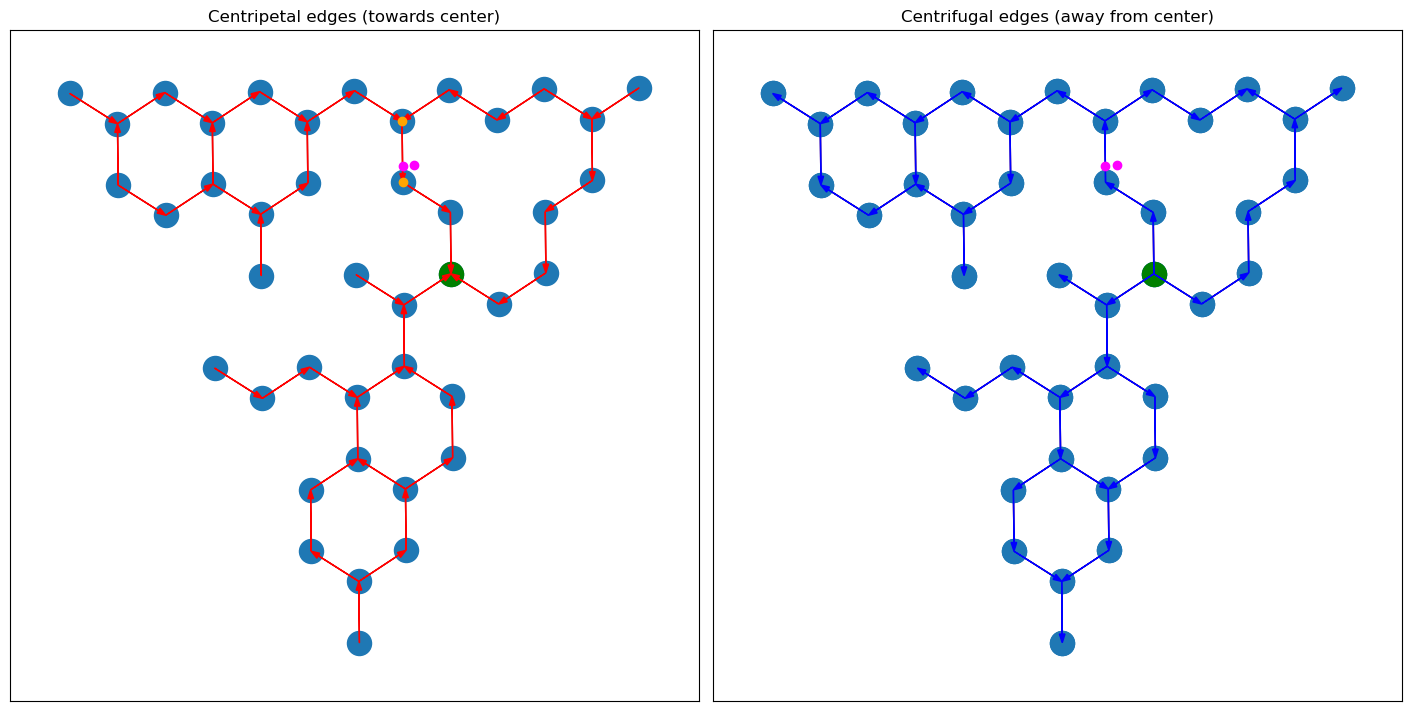

In [475]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True, constrained_layout=True)
# Draw the nodes of the graph
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[0])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[0])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[0])

for u, v in centripetal_edges:
    axes[0].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='red', head_width=1, zorder=10,
                  length_includes_head=True)
axes[0].set_title("Centripetal edges (towards center)")


time_ind = 210_000
axes[0].scatter(linear_position_info.iloc[time_ind]['projected_x_position'],
             linear_position_info.iloc[time_ind]['projected_y_position'],
             color='magenta', zorder=10)
axes[0].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)
node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]

axes[0].scatter(*track_graph.nodes[node1]["pos"], color="orange", zorder=15)
axes[0].scatter(*track_graph.nodes[node2]["pos"], color="orange", zorder=15)

# Draw the centripetal edge direction
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])

nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edgelist=centrifugal_edges, edge_color='r', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[1])
for u, v in centrifugal_edges:
    axes[1].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='blue', head_width=1, zorder=10,
                  length_includes_head=True)
axes[1].set_title("Centrifugal edges (away from center)")

axes[1].scatter(linear_position_info.iloc[time_ind]['projected_x_position'],
             linear_position_info.iloc[time_ind]['projected_y_position'],
             color='magenta', zorder=10)
axes[1].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)

array('centrifugal', dtype='<U11')

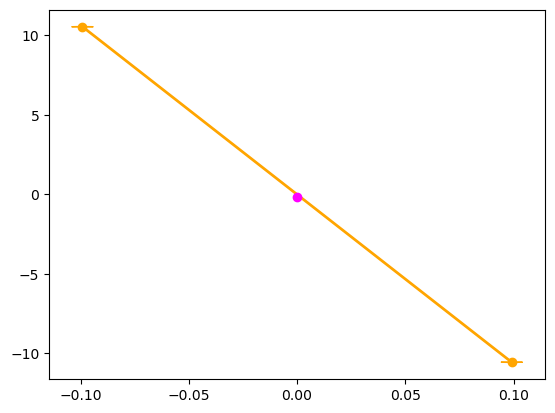

In [505]:
from sklearn.metrics.pairwise import cosine_similarity


dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
pos_vec = position[time_ind] - position[time_ind - 1]

plt.scatter(dir1[0], dir1[1], color='orange')
plt.arrow(0, 0, dir1[0], dir1[1], color='orange', head_width=0.01)
plt.scatter(dir2[0], dir2[1], color='orange')
plt.arrow(0, 0, dir2[0], dir2[1], color='orange', head_width=0.01)
plt.scatter(pos_vec[0], pos_vec[1], color='magenta')
plt.arrow(0, 0, pos_vec[0], pos_vec[1], color='magenta', head_width=0.001)

cos_similarity = cosine_similarity([dir1, dir2], [pos_vec])
most_similar_ind = np.argmin(np.abs(1 - cos_similarity))
edge_direction = [(node1, node2), (node2, node1)][most_similar_ind]
np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

In [641]:
from tqdm.autonotebook import tqdm

def get_movement_direction(time_ind, track_graph, position, linear_position_info, centrifugal_edges):
    node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]
    dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
    dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
    pos_vec = position[time_ind] - position[time_ind - 1]
    cos_similarity = cosine_similarity([pos_vec], [dir1, dir2])
    most_similar_ind = np.argmin(np.abs(1 - cos_similarity))
    edge_direction = [(node2, node1), (node1, node2)][most_similar_ind]
    return np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

movement_dir = [get_movement_direction(time_ind, track_graph, position, linear_position_info, centrifugal_edges) for time_ind in tqdm(range(len(position)))]
movement_dir = np.array(movement_dir)
movement_dir

  0%|          | 0/1613517 [00:00<?, ?it/s]

In [642]:
movement_dir = np.array(movement_dir)
movement_dir

array(['centrifugal', 'centripetal', 'centripetal', ..., 'centrifugal',
       'centrifugal', 'centrifugal'], dtype='<U11')

'centrifugal'

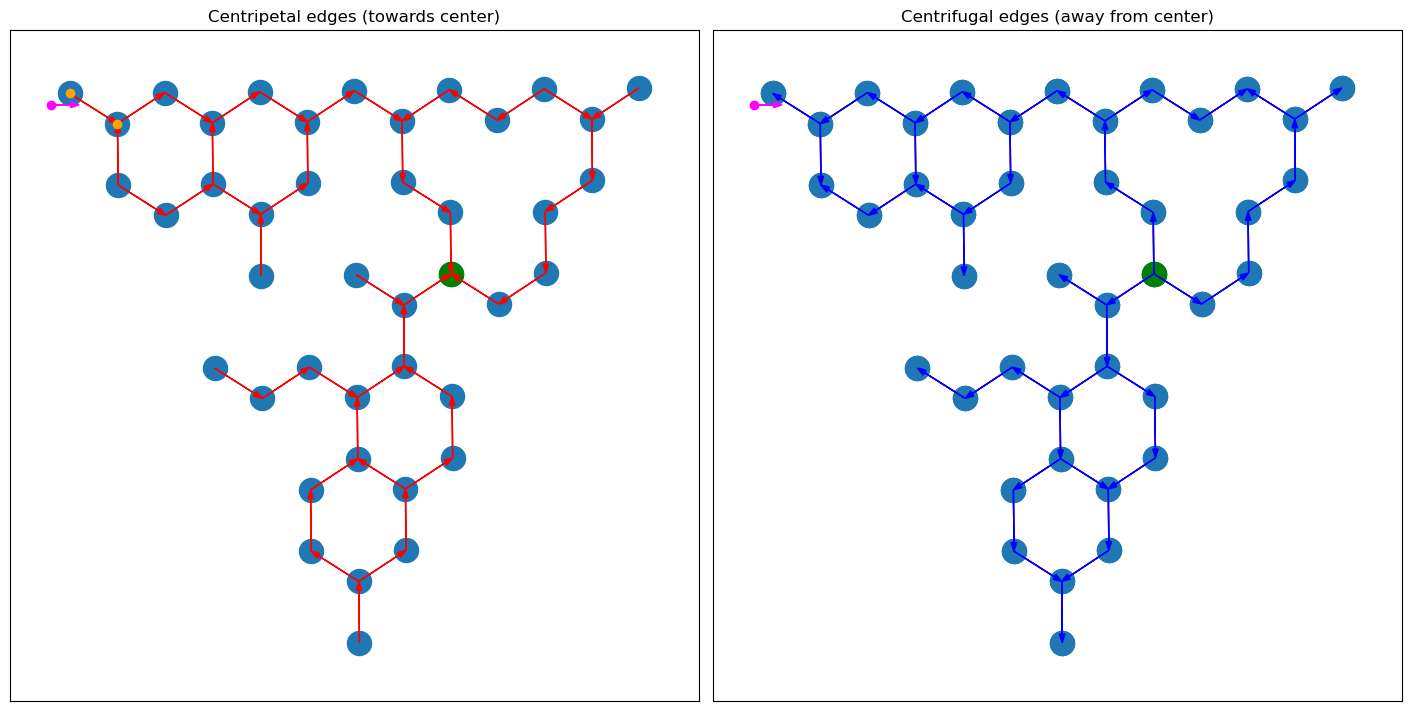

In [663]:
# time_ind = 270_000
# time_ind = 560_000
# time_ind = 680_000
time_ind = 15_000

pos_angle = np.arctan2(position_info.iloc[time_ind]["y"] - position_info.iloc[time_ind - 1]["y"],
           position_info.iloc[time_ind]["x"] - position_info.iloc[time_ind - 1]["x"],)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True, constrained_layout=True)
# Draw the nodes of the graph
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[0])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[0])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[0])

for u, v in centripetal_edges:
    axes[0].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='red', head_width=1, zorder=10,
                  length_includes_head=True)
axes[0].set_title("Centripetal edges (towards center)")


axes[0].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)
node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]

axes[0].scatter(*track_graph.nodes[node1]["pos"], color="orange", zorder=15)
axes[0].scatter(*track_graph.nodes[node2]["pos"], color="orange", zorder=15)

axes[0].arrow(position_info.iloc[time_ind - 1]["x"], position_info.iloc[time_ind - 1]["y"],
          5 * np.cos(pos_angle), 5 * np.sin(pos_angle), color='magenta', head_width=1, length_includes_head=True, zorder=10)


# Draw the centripetal edge direction
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])

nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edgelist=centrifugal_edges, edge_color='r', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[1])
for u, v in centrifugal_edges:
    axes[1].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='blue', head_width=1, zorder=10,
                  length_includes_head=True)
axes[1].set_title("Centrifugal edges (away from center)")

axes[1].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)

axes[1].arrow(position_info.iloc[time_ind - 1]["x"], position_info.iloc[time_ind - 1]["y"],
          5 * np.cos(pos_angle), 5 * np.sin(pos_angle), color='magenta', head_width=1, length_includes_head=True, zorder=10)

movement_dir[time_ind]

In [ ]:
# just use head direction

In [572]:
node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]
dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
pos_vec = position[time_ind] - position[time_ind - 1]
cos_similarity = cosine_similarity([pos_vec], [dir1, dir2])
most_similar_ind = np.argmin(np.abs(1 - cos_similarity))
edge_direction = [(node1, node2), (node2, node1)][most_similar_ind]
np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

array('centrifugal', dtype='<U11')

In [580]:
from tqdm.autonotebook import tqdm

def get_movement_direction(time_ind, track_graph, position, linear_position_info, centrifugal_edges):
    node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]
    dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
    dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
    pos_vec = position[time_ind] - position[time_ind - 1]
    cos_similarity = cosine_similarity([pos_vec], [dir1, dir2])
    most_similar_ind = np.argmin(np.abs(1 - cos_similarity))
    edge_direction = [(node1, node2), (node2, node1)][most_similar_ind]
    return np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

# Precompute the list of edges and positions
edges = np.array(list(track_graph.edges))
node_positions = np.array([track_graph.nodes[node]["pos"] for node in track_graph.nodes])

# Compute the node indices, directions, and position vectors for all time indices
node_indices = edges[linear_position_info.track_segment_id.astype(int)]
dir1 = positions[node_indices[:, 0]] - positions[node_indices[:, 1]]
dir2 = positions[node_indices[:, 1]] - positions[node_indices[:, 0]]
pos_vec = position[1:] - position[:-1]

# Compute the cosine similarity for all time indices
cos_similarity = cosine_similarity(pos_vec, np.stack([dir1, dir2], axis=1))

# Determine the most similar direction for all time indices
most_similar_ind = np.argmin(np.abs(1 - cos_similarity), axis=1)
edge_direction = np.where(most_similar_ind, node_indices[:, ::-1], node_indices)

# Determine the movement direction for all time indices
movement_dir = np.where(np.isin(edge_direction, centrifugal_edges).any(axis=1), 'centrifugal', 'centripetal')

IndexError: index 42 is out of bounds for axis 0 with size 42

In [582]:
node_indices

array([[13, 17],
       [13, 17],
       [13, 17],
       ...,
       [ 0,  3],
       [ 0,  3],
       [ 0,  3]])

array([-0.98925969,  0.98925969])

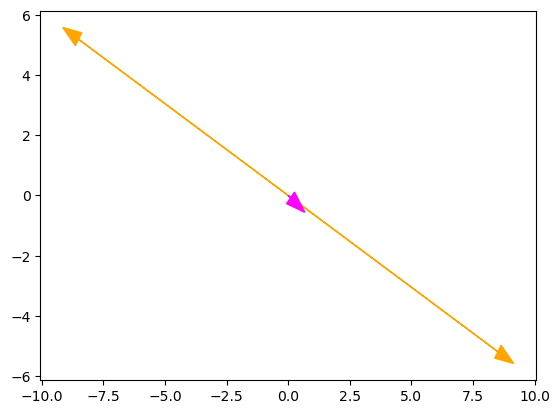

In [562]:
plt.arrow(0, 0, dir1[0], dir1[1], color='orange', head_width=0.5)
plt.arrow(0, 0, dir2[0], dir2[1], color='orange', head_width=0.5)
plt.arrow(0, 0, pos_vec[0], pos_vec[1], color='magenta', head_width=0.5)

cos_similarity.squeeze()

In [700]:
def get_edge_direction_mapping(node1, node2, centripetal_edges, centrifugal_edges):

    if (node1, node2) in centripetal_edges and (node2, node1) in centrifugal_edges:
        return {
            (node1, node2): "centripetal (towards center)",
            (node2, node1): "centrifugal (away from center)"
        }
    elif (node1, node2) in centrifugal_edges and (node2, node1) in centripetal_edges:
        return {
            (node1, node2): "centrifugal (away from center)",
            (node2, node1): "centripetal (towards center)"
        }
    else:
        print("error")

array('centripetal', dtype='<U11')

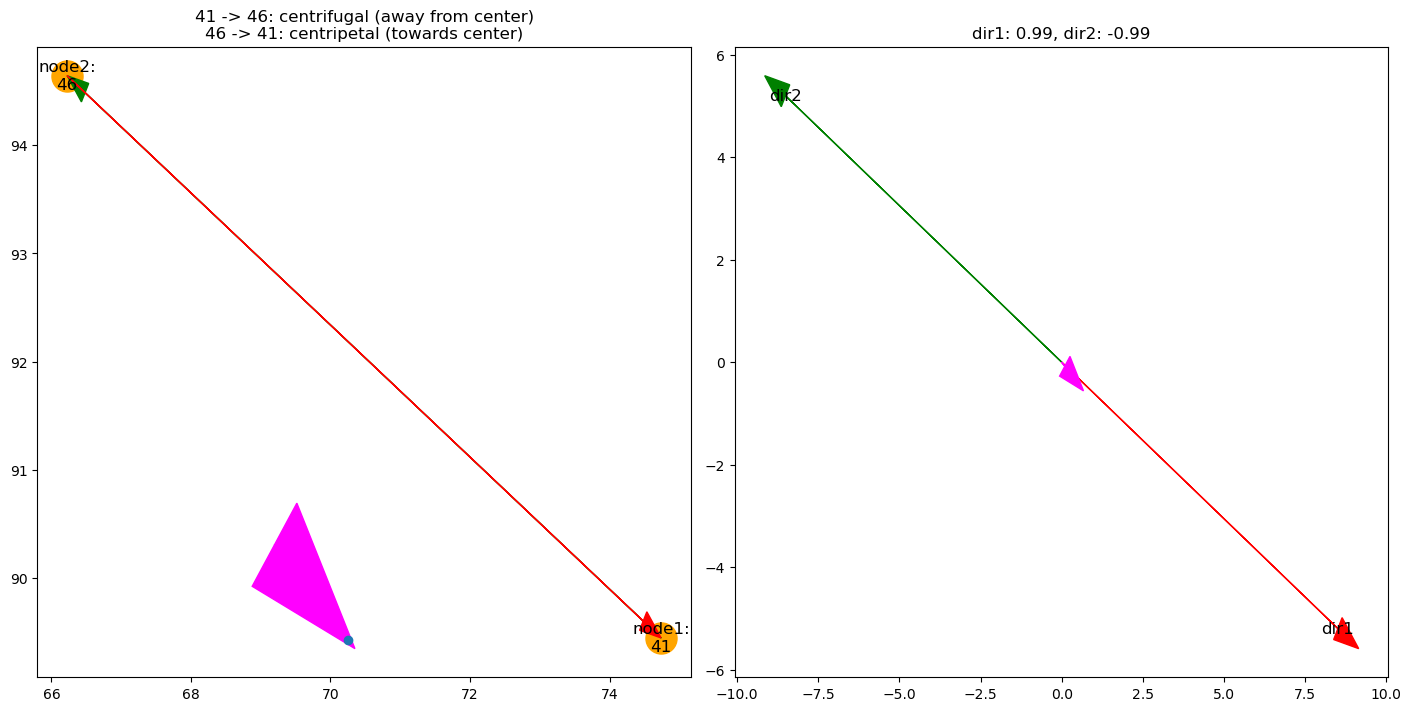

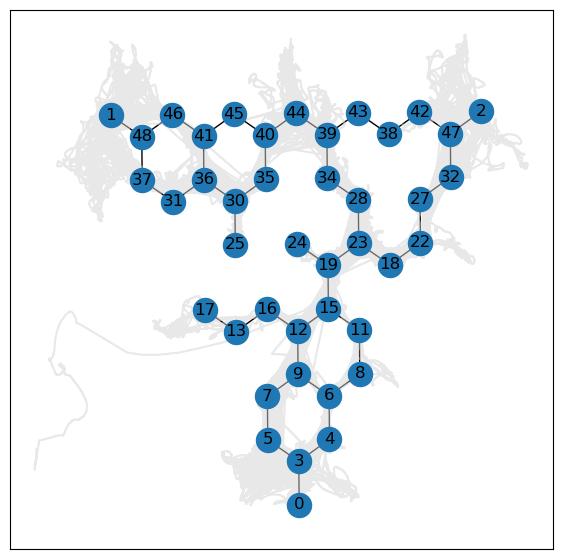

In [717]:
time_ind = 270_000

pos_angle = np.arctan2(position_info.iloc[time_ind]["y"] - position_info.iloc[time_ind - 1]["y"],
           position_info.iloc[time_ind]["x"] - position_info.iloc[time_ind - 1]["x"],)

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True, constrained_layout=True)
# Draw the nodes of the graph
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[0])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[0])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[0])

for u, v in centripetal_edges:
    axes[0].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='red', head_width=1, zorder=10,
                  length_includes_head=True)
axes[0].set_title("Centripetal edges (towards center)")


axes[0].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)
node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]

axes[0].scatter(*track_graph.nodes[node1]["pos"], color="orange", zorder=15)
axes[0].scatter(*track_graph.nodes[node2]["pos"], color="orange", zorder=15)

axes[0].arrow(position_info.iloc[time_ind - 1]["x"], position_info.iloc[time_ind - 1]["y"],
          5 * np.cos(pos_angle), 5 * np.sin(pos_angle), color='magenta', head_width=1, length_includes_head=True, zorder=10)


# Draw the centripetal edge direction
nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])

nx.draw_networkx_nodes(track_graph, pos=node_positions, ax=axes[1])
nx.draw_networkx_nodes(track_graph, pos=node_positions, nodelist=[center_node], node_color='green', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edgelist=centrifugal_edges, edge_color='r', ax=axes[1])
nx.draw_networkx_edges(track_graph, pos=node_positions, edge_color='grey', ax=axes[1])
for u, v in centrifugal_edges:
    axes[1].arrow(node_positions[u][0], node_positions[u][1],
                  node_positions[v][0] - node_positions[u][0],
                  node_positions[v][1] - node_positions[u][1],
                  color='blue', head_width=1, zorder=10,
                  length_includes_head=True)
axes[1].set_title("Centrifugal edges (away from center)")

axes[1].scatter(position_info.iloc[time_ind]['x'],
             position_info.iloc[time_ind]['y'],
             color='magenta', zorder=10)

axes[1].arrow(position_info.iloc[time_ind - 1]["x"], position_info.iloc[time_ind - 1]["y"],
          5 * np.cos(pos_angle), 5 * np.sin(pos_angle), color='magenta', head_width=1, length_includes_head=True, zorder=10)

movement_dir[time_ind]

# Correct answer is centripetal

node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]
dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
pos_vec = position[time_ind] - position[time_ind - 1]
cos_similarity = cosine_similarity([pos_vec], [dir1, dir2]).squeeze()
most_similar_ind = np.argmin(np.abs(1.0 - cos_similarity))
edge_direction = [(node2, node1), (node1, node2)][most_similar_ind]

fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

axes[0].scatter(track_graph.nodes[node1]["pos"][0], track_graph.nodes[node1]["pos"][1], color='orange', s=500)
axes[0].text(track_graph.nodes[node1]["pos"][0], track_graph.nodes[node1]["pos"][1], f'node1:\n{node1}', fontsize=12, ha='center', va='center')
axes[0].scatter(track_graph.nodes[node2]["pos"][0], track_graph.nodes[node2]["pos"][1], color='orange', s=500)
axes[0].text(track_graph.nodes[node2]["pos"][0], track_graph.nodes[node2]["pos"][1], f'node2:\n{node2}', fontsize=12, ha='center', va='center')

edge_dir_map = get_edge_direction_mapping(node1, node2, centripetal_edges, centrifugal_edges)
axes[0].set_title(f"{node1} -> {node2}: {edge_dir_map[node1, node2]}\n"
                  f"{node2} -> {node1}: {edge_dir_map[node2, node1]}")
axes[0].arrow(
    track_graph.nodes[node1]["pos"][0], track_graph.nodes[node1]["pos"][1],
    dir2[0], dir2[1], color='green', head_width=0.2, length_includes_head=True)
axes[0].arrow(
    track_graph.nodes[node2]["pos"][0], track_graph.nodes[node2]["pos"][1],
    dir1[0], dir1[1], color='red', head_width=0.2, length_includes_head=True
)
axes[0].arrow(position[time_ind-1, 0], position[time_ind-1, 1], pos_vec[0], pos_vec[1],color='magenta', head_width=1, length_includes_head=True)
axes[0].scatter(position[time_ind-1, 0], position[time_ind-1, 1])

axes[1].arrow(0, 0, dir1[0], dir1[1], color='red', head_width=0.5)
axes[1].text(dir1[0], dir1[1], 'dir1', fontsize=12, ha='center', va='center')
axes[1].arrow(0, 0, dir2[0], dir2[1], color='green', head_width=0.5)
axes[1].text(dir2[0], dir2[1], 'dir2', fontsize=12, ha='center', va='center')
axes[1].arrow(0, 0, pos_vec[0], pos_vec[1], color='magenta', head_width=0.5)

axes[1].set_title(f"dir1: {cos_similarity[0]:.2f}, dir2: {cos_similarity[1]:.2f}")

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(position_info['x'], position_info['y'], color="lightgrey", alpha=0.5)
plot_track_graph(track_graph, ax=ax)

np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

In [706]:
plt.arrow?

Signature: plt.arrow(x, y, dx, dy, **kwargs)
Docstring:
Add an arrow to the Axes.

This draws an arrow from ``(x, y)`` to ``(x+dx, y+dy)``.

Parameters
----------
x, y : float
    The x and y coordinates of the arrow base.

dx, dy : float
    The length of the arrow along x and y direction.

width : float, default: 0.001
    Width of full arrow tail.

length_includes_head : bool, default: False
    True if head is to be counted in calculating the length.

head_width : float or None, default: 3*width
    Total width of the full arrow head.

head_length : float or None, default: 1.5*head_width
    Length of arrow head.

shape : {'full', 'left', 'right'}, default: 'full'
    Draw the left-half, right-half, or full arrow.

overhang : float, default: 0
    Fraction that the arrow is swept back (0 overhang means
    triangular shape). Can be negative or greater than one.

head_starts_at_zero : bool, default: False
    If True, the head starts being drawn at coordinate 0
    instead of ending

In [699]:
centripetal_edges

[(0, 3),
 (1, 48),
 (2, 47),
 (3, 4),
 (3, 5),
 (4, 6),
 (5, 7),
 (6, 8),
 (6, 9),
 (7, 9),
 (8, 11),
 (9, 12),
 (11, 15),
 (12, 15),
 (16, 12),
 (13, 16),
 (17, 13),
 (15, 19),
 (22, 18),
 (18, 23),
 (19, 23),
 (24, 19),
 (27, 22),
 (28, 23),
 (25, 30),
 (32, 27),
 (34, 28),
 (30, 35),
 (36, 30),
 (31, 36),
 (37, 31),
 (47, 32),
 (39, 34),
 (35, 40),
 (36, 41),
 (37, 48),
 (42, 38),
 (38, 43),
 (43, 39),
 (44, 39),
 (40, 44),
 (45, 40),
 (41, 45),
 (46, 41),
 (42, 47),
 (48, 46)]

In [666]:
time_ind = 15_000

# Correct answer is centripetal

node1, node2 = list(track_graph.edges)[int(linear_position_info.iloc[time_ind].track_segment_id)]
dir1 = np.array(track_graph.nodes[node1]["pos"]) - np.array(track_graph.nodes[node2]["pos"])
dir2 = np.array(track_graph.nodes[node2]["pos"]) - np.array(track_graph.nodes[node1]["pos"])
pos_vec = position[time_ind] - position[time_ind - 1]
cos_similarity = cosine_similarity([pos_vec], [dir1, dir2]).squeeze()
most_similar_ind = np.argmin(np.abs(1.0 - cos_similarity))
edge_direction = [(node2, node1), (node1, node2)][most_similar_ind]

np.where(edge_direction in centrifugal_edges, 'centrifugal', 'centripetal')

array('centrifugal', dtype='<U11')

(0, 0.7071067811865475)

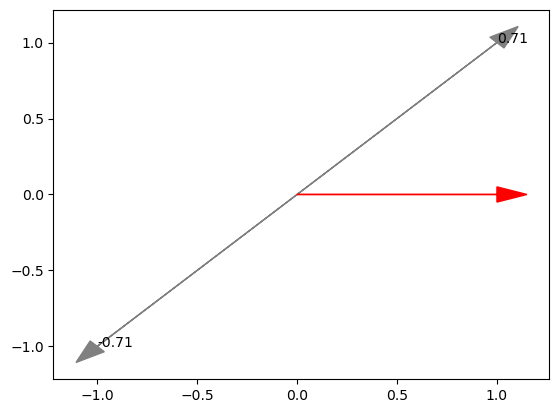

In [632]:
x = np.array([1, 0])[None]
# y = np.array(
#     [[1, 0],
#      [0, 1],
#      [1, 1],
#      [1, -1],
#      [-1, 1],
#      [0, -1],
#      [-1, 0],
#      [-1, -1],
# ])
y = np.array([
     [1, 1],
     [-1, -1],
])
cs = cosine_similarity(x, y)

plt.arrow(0, 0, x[0, 0], x[0, 1], head_width=0.1, color='red', zorder=11)
for ind, y_ in enumerate(y):
    plt.arrow(0, 0, y_[0], y_[1], head_width=0.1, color='grey', zorder=10)
    plt.text(y_[0], y_[1], f"{cs[0, ind]:.2f}", zorder=11)


np.argmin(np.abs(1 - cs)), cs[0, np.argmin(np.abs(1 - cs))]

In [614]:
cs.shape

(1, 5)